In [1]:
#Installing required libraries for social equity analysis of flood riska cross D.C. Wards
!pip install geopandas pandas matplotlib

import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

#Loading GeoJson files
wards = gpd.read_file('Wards_from_2022.geojson')
flood_risk = gpd.read_file('Storm_Surge_Risk_Areas.geojson')

In [2]:
#Reprojecting for accurate area calculations
wards = wards.to_crs(epsg = 26918)
flood_risk = flood_risk.to_crs(epsg = 26918)

#Calculate flood risk percentages
flooded_areas = gpd.overlay(wards, flood_risk, how = 'intersection')
flooded_areas['flooded_area'] = flooded_areas.geometry.area
wards['total_area'] = wards.geometry.area

#Merging results
result = wards.merge(
    flooded_areas.groupby('WARD')['flooded_area'].sum().reset_index(),
    on = 'WARD',
    how = 'left'
).fillna(0) #Fills NA with 0 for any Wards with no flooding
result['flood_pct'] = (result['flooded_area'] / result['total_area']) * 100

/tmp/ipython-input-2-1268021861.py:15: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ).fillna(0) #Fills NA with 0 for any Wards with no flooding


In [3]:
#Social Equity Analysis ("This is where the fun begins!" - Anakin Skywalker)

#Poverty data below
poverty_data = {
    'WARD': ['1', '2', '3', '4', '5', '6', '7', '8'],
    'poverty_rate': [13.0, 13.9, 8.4, 11.2, 17.2, 13.1, 26.6, 35.7],
    'median_income': [93284, 104504, 122680, 82625, 63552, 102214, 40021, 31954]
}

#Converting to DataFrame
poverty_df = pd.DataFrame(poverty_data)
poverty_df['WARD'] = poverty_df['WARD'].astype(str) #Forces string type
result['WARD'] = result['WARD'].astype(str) #Also forces string type

#Merging with flood results
equity_analysis = result.merge(
    poverty_df,
    on = 'WARD',
    how = 'left' #Maintains all wards even if there is no poverty data
)

#Calculating vulnerability score
equity_analysis['vulnerability_score'] = (
    equity_analysis['flood_pct'] * 0.7 + #70% weight on flood risk
    equity_analysis['poverty_rate'] * 0.3 #30% weight on poverty rate
)

#Sorting by most vulnerable
equity_analysis = equity_analysis.sort_values('vulnerability_score', ascending = False)

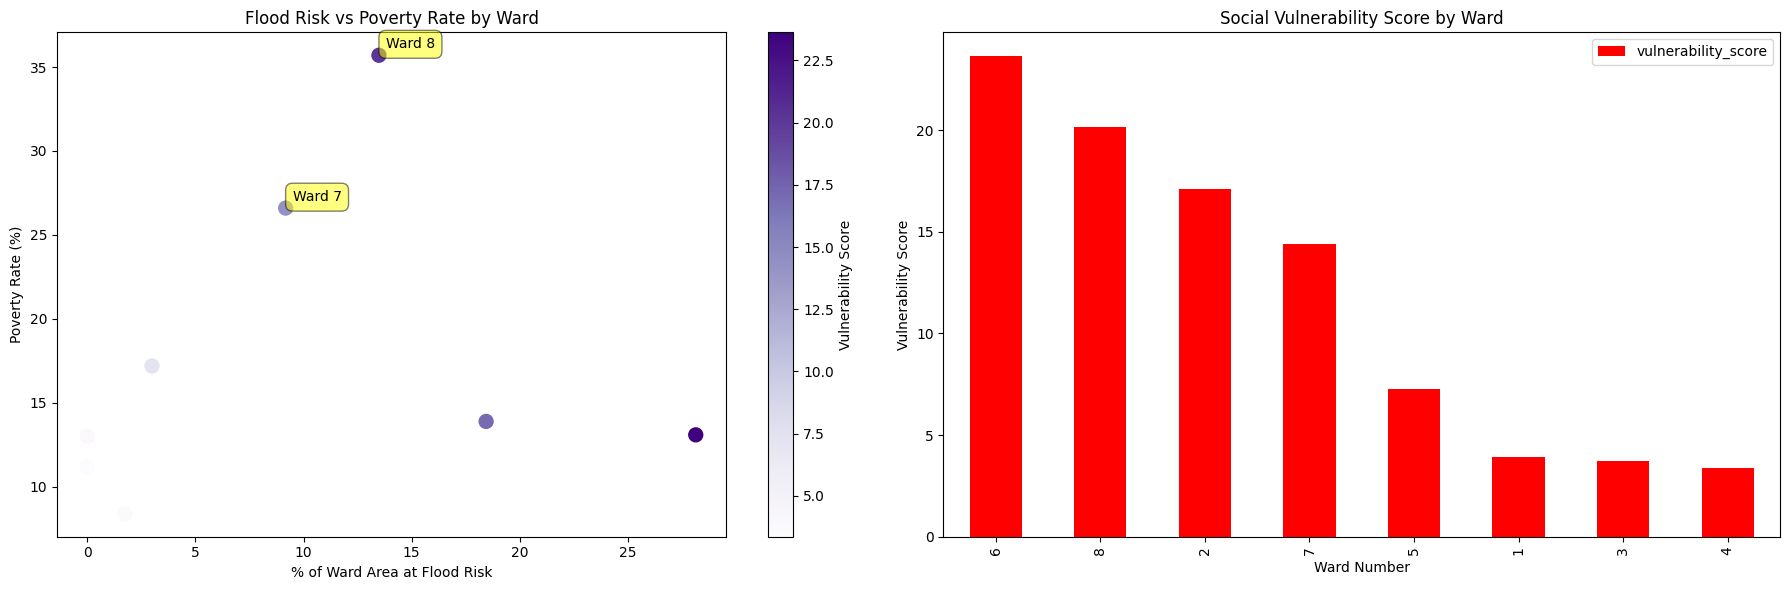


Social Equity Analysis Results:


,WARD,flood_pct,poverty_rate,median_income,vulnerability_score
1,6,28.140591,13.1,102214,23.628413
0,8,13.486583,35.7,31954,20.150608
3,2,18.444991,13.9,104504,17.081494
2,7,9.172365,26.6,40021,14.400656
5,5,2.990070,17.2,63552,7.253049
4,1,0.000000,13.0,93284,3.900000
6,3,1.744317,8.4,122680,3.741022
7,4,0.000000,11.2,82625,3.360000


In [9]:
#Visualization ("This is [also] where the fun begins!" - Anakin Skywalker...again)

#Figure setup
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (18, 6))

# 1. Flood Risk vs Poverty Scatter Plot
scatter = ax1.scatter(
    equity_analysis['flood_pct'],
    equity_analysis['poverty_rate'],
    c = equity_analysis['vulnerability_score'],
    cmap = 'Purples',
    s = 100
)
ax1.set_title('Flood Risk vs Poverty Rate by Ward')
ax1.set_xlabel('% of Ward Area at Flood Risk')
ax1.set_ylabel('Poverty Rate (%)')
fig.colorbar(scatter, ax = ax1, label = 'Vulnerability Score')

#Highlighting Wards 7 and 8
for i, row in equity_analysis.iterrows():
    if row['WARD'] in ['7', '8']:
        ax1.annotate(
            f"Ward {row['WARD']}",
            (row['flood_pct'], row['poverty_rate']),
            xytext = (5, 5),
            textcoords = 'offset points',
            bbox = dict(boxstyle = 'round, pad = 0.5', fc = 'yellow', alpha = 0.5)
        )

# 2. Vulnerability Score Chart
equity_analysis.plot(
    x = 'WARD',
    y = 'vulnerability_score',
    kind = 'bar',
    color = 'red',
    ax = ax2,
    title = 'Social Vulnerability Score by Ward'
)
ax2.set_ylabel('Vulnerability Score')
ax2.set_xlabel('Ward Number')

plt.tight_layout()
plt.show()

#Display final table
print("\nSocial Equity Analysis Results:")
display(equity_analysis[['WARD', 'flood_pct', 'poverty_rate', 'median_income', 'vulnerability_score']])

#Exporting as a file (optional; could be used for geospatial analysis in ArcGIS)
equity_analysis.to_file('equity_analysis.geojson', driver = 'GeoJSON')